# Поиск зон роста для маркетинговых кампаний

## Описание проекта
**Цель исследования:** В большой сети мебельных магазинов рекламой занимаются несколько менеджеров. Они в рамках своих компетенций оптимизируют и управляют рекламными кампаниями. Необходимо увеличить доход не менее чем на 10% при сохранении текущего бюджета.

**Задачи исследования:**
Проанализировать данные по кампаниям, найти зоны роста и сформировать пул гипотез/ предложений на следующий месяц в виде списка обоснованных гипотез, по желанию в виде простейшего дашборда.

**Исходные данные:** датасет с параметрами кампаний за предыдущий месяц.

In [1]:
import pandas as pd # импорт библиотеки pandas
import numpy as np  # импорт библиотеки numpy
from scipy.optimize import minimize # импорт модуля optimize из библиотеки numpy
import warnings # импорт библиотеки warnings
import seaborn as sns # импорт библиотеки seaborn
import matplotlib.pyplot as plt # импорт библиотеки matplot
import math # импорт библиотеки math
import re # импорт библиотеки re

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning) # отключение уведомлений об устаревшем коде
pd.options.mode.chained_assignment = None  # default='warn'

От заказчика:
1) Тут ROI стандартное от гугл аналитики, кривое, очень коррелирует  с доходом от клика) я бы не рекомендовала обращать особое внимание на производные параметры
2) доход - это выручка
3) конверсия и транзакция - это хороший вопрос. это разные  понятия как яблоки и груши) конверсия - это выполненное целевое действие на сайте, а транзакция - это екоммерс событие, типа конверсия в заказ, и  завершенный заказ как транзакция  - это разные сущности. В Екоме всегда важнее транзакция (подтвержденный заказ). Но опять же, ваши верхнеуровневые метрики это доход и расход. Не нужно усложнять
4) Бюджет - это цена за клик * количество кликов
5) Брендовый трафик приносит самую большую конверсию, но он его и некуда раститьь

## Изучение данных из файлов

Загрузим данные из файла.

In [3]:
df = pd.read_csv('YD_20220801-20220831.csv', decimal=",") # загрузим данные из файла

Посмотрим на структуру данных в таблице.

In [4]:
df.info() # просмотр информации о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Кампания                             500 non-null    object 
 1   Стоимость                            500 non-null    float64
 2   Цена за клик                         500 non-null    float64
 3   Цена за конверсию                    500 non-null    float64
 4   Цена за транзакцию                   500 non-null    float64
 5   Доход от клика                       500 non-null    float64
 6   Доход                                500 non-null    float64
 7   Рентабельность инвестиций в рекламу  500 non-null    object 
dtypes: float64(6), object(2)
memory usage: 31.4+ KB


Посмотрим как выглядят данные в таблице.

In [5]:
df.sample(5) # просмотр образца данных

,Кампания,Стоимость,Цена за клик,Цена за конверсию,Цена за транзакцию,Доход от клика,Доход,Рентабельность инвестиций в рекламу
31,yd_spb_couches_all-types_network_v4_ctr,49677.59,53.59,558.18,0.00,0.00,0.0,"0,00%"
12,yd_msk_couches_general-akcii_network-v2_cpa,73142.54,5.92,1108.22,0.00,0.03,0.0,"0,55%"
358,yd_chel_couches_kreslo_all-types_search_ruchka,45760.68,50.29,788.98,22880.34,64.29,58440.0,"127,86%"
257,yd_tyum_wardrobe_generic_search_v5,47649.44,84.79,1162.18,47649.44,19.56,10990.0,"23,06%"
390,yd_ros_couches_all-types_general_network,72669.35,66.06,576.74,36334.68,75.32,82670.0,"114,01%"


### Описание данных:
* `Кампания` - название кампании;
* `Стоимость` - расходы на кампанию, руб.;
* `Цена за клик`- цена за клик, руб.
* `Цена за конверсию` - цена за конверсию, руб.
* `Цена за транзакцию` - цена за транзакцию, руб.
* `Доход от клика` - доход от клика, руб.
* `Доход` - доход от кампании, руб.
* `Рентабельность инвестиций в рекламу` - рентабельность кампании.

### Вывод

Пропуски в данных отсутствуют. Типы данных во всех столбцах соответствуют содержимому, за исключением столбца `Рентабельность инвестиций в рекламу`, его необходимо преобразовать в числовой формат.

## Предобработка данных

### Переименование столбцов

Для удобства работы приведем названия столбцов в соответствие с правилами именования: назовем столбцы в латинице и строчными символами.

In [6]:
df.columns=['promo', 'costs', 'cpc', 'cpa', 'cpt', 'epc', 'earnings', 'roi'] # переименование столбцов
df.columns

Index(['promo', 'costs', 'cpc', 'cpa', 'cpt', 'epc', 'earnings', 'roi'], dtype='object')

In [7]:
df.info() # просмотр информации о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   promo     500 non-null    object 
 1   costs     500 non-null    float64
 2   cpc       500 non-null    float64
 3   cpa       500 non-null    float64
 4   cpt       500 non-null    float64
 5   epc       500 non-null    float64
 6   earnings  500 non-null    float64
 7   roi       500 non-null    object 
dtypes: float64(6), object(2)
memory usage: 31.4+ KB


Столбцы успешно переименованы.

### Изменение типов данных

Приведем значения столбца `roi` к числовому формату.

In [8]:
try:
    df['roi'] = df['roi'].str.rstrip('%').str.replace(',','.').astype('float') / 100.0 # преобразование процентов в число
except:
    print('Ошибка преобразования типа данных')

In [9]:
df.info() # просмотр информации о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   promo     500 non-null    object 
 1   costs     500 non-null    float64
 2   cpc       500 non-null    float64
 3   cpa       500 non-null    float64
 4   cpt       500 non-null    float64
 5   epc       500 non-null    float64
 6   earnings  500 non-null    float64
 7   roi       500 non-null    float64
dtypes: float64(7), object(1)
memory usage: 31.4+ KB


Типы данных успешно преобразованы.

### Поиск дубликатов

Проверим таблицу на наличие явных дубликатов.

In [10]:
print('Количество дублирующихся строк в таблице "df":', df.duplicated().sum()) # подсчёт явных дубликатов

Количество дублирующихся строк в таблице "df": 0


Явных дубликатов не обнаружено.

### Выводы

1. Мы привели названия столбцов в соответствие с правилами именования: сделали названия столбцов в латинице и строчными символами.
2. Мы привели значения столбца `roi` к числовому формату.
3. Явных дубликатов в данных не обнаружено.

## Расчет дополнительных параметров

Из названия кампании попробуем выделить значения региона и вида рекламного мероприятия.

Выделим код региона регулярным выражением.

In [11]:
df['region'] = df.promo.apply(lambda x:  re.search(r'(?<=\_)(.*?)(?=\_)',x).group()) # применим регулярное выражение к названиям кампаний

Посмотрим, какие регионы удалось выделить.

In [12]:
df.region.unique()        

array(['msk', 'chel', 'spb', 'nsk', 'tvr', 'kra', 'nnov', 'vor', 'kazan',
       'ros', 'orel', 'perm', 'ryz', 'vlg', 'vld', 'kal', 'yar', 'tul',
       'smol', 'barn', 'sim', 'tmsk', 'sta', 'tyum', 'tamb', 'sarat',
       'lip', 'kursk', 'sev', 'ekb', 'belg', 'cfo', 'bryan', 'ufa',
       'volgd', 'tolyat', 'ivanovo', 'vlad', 'reg', 'countries'],
      dtype=object)

Выделенные регионы можно использовать при анализе.

Выделим из названия кампании виды основных рекламных мероприятий.

In [13]:
string_lst = ['brand_search', 'brand_network', 'general_search',  'generic_search', 'generic_network', 'all-types_search', 'all-types_network', 
              'all-types_category_network',  'all-types_general_network', 'size_search', 'size_network', 'selling-words_search', 
              'selling-words_network',  'general-words_search',  'general-words_network', 'specific_search', 'retargeting_new', 
               'dsa_search', 'dsa_pg_search', 'mkb_search', 'competitors_big_network', 'competitors_big_search' 
] #  создадим список видов кампаний
df['type'] = df.promo.apply(lambda x: ''.join(re.findall(r"(?=("+'|'.join(string_lst)+r"))", x))) # применим регулярное выражение к названиям кампаний

In [14]:
df['type'].value_counts() # посчитаем число выделенных кампаний

                              78
all-types_search              57
retargeting_new               56
all-types_general_network     54
all-types_network             52
all-types_category_network    34
generic_search                29
brand_search                  26
general-words_search          26
dsa_pg_search                 23
selling-words_search          11
general-words_network         11
general_search                 7
competitors_big_network        7
brand_network                  7
dsa_search                     6
selling-words_network          4
generic_network                3
mkb_search                     2
size_network                   2
size_search                    2
specific_search                2
competitors_big_search         1
Name: type, dtype: int64

Не удалось идентифицировать 78 мероприятий. Попробуем работать с теми, что есть.

В исходных данных использовано стандартное ROI от гугл аналитики, оно не вполне адекватно отражает эффективность. Рассчитаем ROI самостоятельно. 

In [15]:
df['roi_calc'] = df['earnings']/df['costs'] # рассчитаем ROI

In [16]:
df.sample(5) # просмотр образца данных

,promo,costs,cpc,cpa,cpt,epc,earnings,roi,region,type,roi_calc
296,yd_msk_couches_razm_general-words_search-v2,92789.79,55.33,806.87,92789.79,14.43,23990.0,0.2608,msk,general-words_search,0.258541
97,yd_tvr_couches_general-words_search-v3,32704.07,87.68,743.27,0.00,0.00,0.0,0.0000,tvr,general-words_search,0.000000
408,yd_spb_competitors_big_network,145438.60,71.22,337.44,36359.65,59.51,120190.0,0.8355,spb,competitors_big_network,0.826397
308,yd_msk_couches_geo_search-v2_new,93931.84,68.46,1219.89,93931.84,22.44,29990.0,0.3277,msk,,0.319274
157,yd_sta_couches_all-types_network_v4,22617.08,27.75,426.74,0.00,0.24,0.0,0.0087,sta,all-types_network,0.000000


Необходимые дополнительные параметры рассчитаны.

### Выводы
1. Из названия кампании мы выделили значения региона и вида рекламного мероприятия, используя регулярные выражения.
2. В исходных данных использовано стандартное ROI от гугл аналитики, оно не вполне адекватно отражает эффективность. Мы рассчитали ROI самостоятельно.

## Исследовательский анализ данных

Посмотрим регионы с наибольшим числом кампаний.

In [17]:
(df.groupby('region') # сгруппируем данные по регионам
    .agg({'roi':'mean','roi_calc':'mean','promo':'count'})
    .sort_values('promo', ascending=False)
    .head(10)
)

,roi,roi_calc,promo
region,,,
msk,1.363143,1.340616,89
spb,1.408833,1.391178,45
kra,1.286900,1.267724,26
ekb,1.415600,1.404221,19
yar,0.736012,0.724008,16
vld,1.637793,1.630525,15
vor,1.511457,1.499386,14
sta,1.315369,1.288466,13
ufa,0.481162,0.468525,13


Наибольшее число кампаний проводилось в Москве и Санкт-Петербурге.

Посмотрим средние значения ROI по типам рекламных мероприятий.

In [18]:
(df.groupby('type') # сгруппируем данные по типам рекламных мероприятий
    .agg({'roi':'mean','roi_calc':'mean','promo':'count'})
    .sort_values('roi', ascending=False)
)

,roi,roi_calc,promo
type,,,
brand_search,7.706446,7.624077,26
general-words_network,1.421245,1.408612,11
retargeting_new,1.323770,1.305278,56
dsa_search,1.295917,1.287934,6
competitors_big_search,1.272400,1.269794,1
,1.140656,1.122054,78
selling-words_search,1.128191,1.099664,11
brand_network,0.917714,0.904586,7
generic_search,0.789152,0.776747,29


Наивысшим средним ROI обладает brand_search. Но при расчете бюджета следует учесть, что емкость этого канала уже исчерпана.

Построим тепловые карты по регионам и типам рекламных мероприятий.

In [19]:
promo_reg = df.pivot_table(index='region', columns='type', values='roi_calc', aggfunc='mean') # строим таблицу для тепловой карты

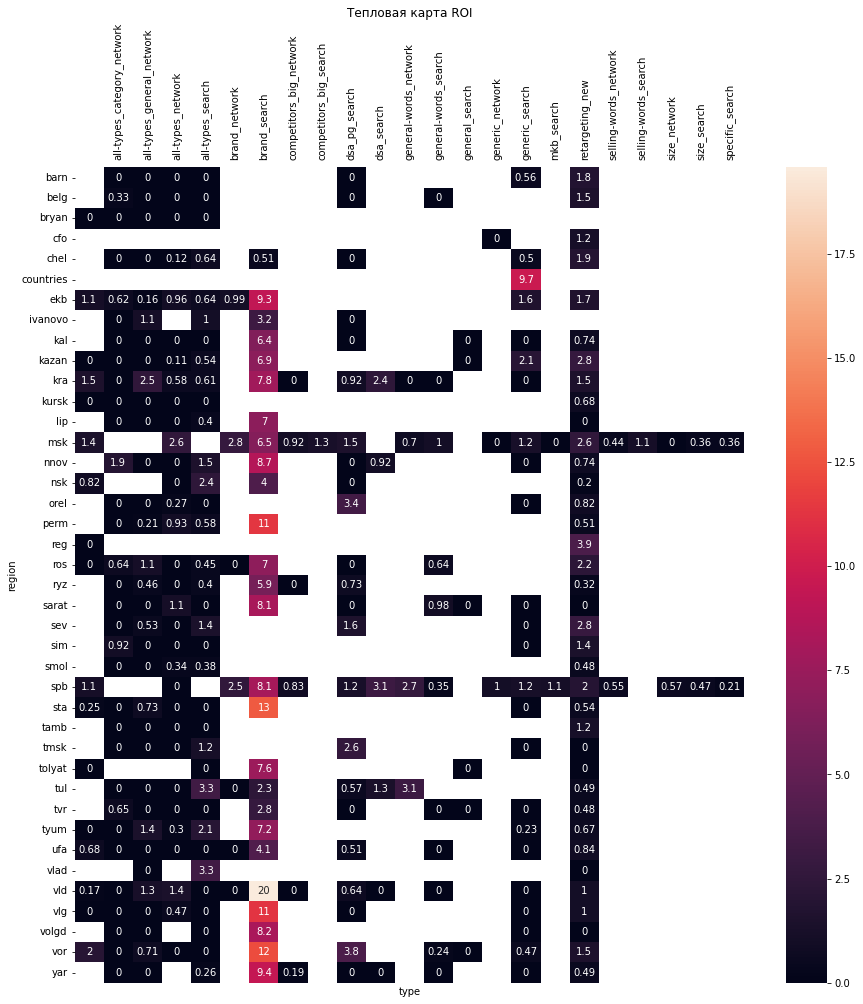

In [20]:
plt.figure(figsize = (15, 15)) # строим тепловую карту
sns.heatmap(
    promo_reg, annot=True
) 
plt.title('Тепловая карта ROI')
plt.tick_params(axis='x', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True, rotation=90)
plt.show()

Мы видим, что большинство типов рекламных мероприятий используется только в Москве и Санкт-Петербурге. Чтобы не потерять рекламные кампании в регионах, выделим срез кампаний проводимых по большинству регионов (исключив еще и "слишком эффективный" `brand_search`).

In [21]:
slice = ['all-types_search', # создаем список региональных кампаний 
 'generic_search',
 'all-types_network',
 'dsa_pg_search',
 'retargeting_new',
 'all-types_general_network',
 'all-types_category_network']

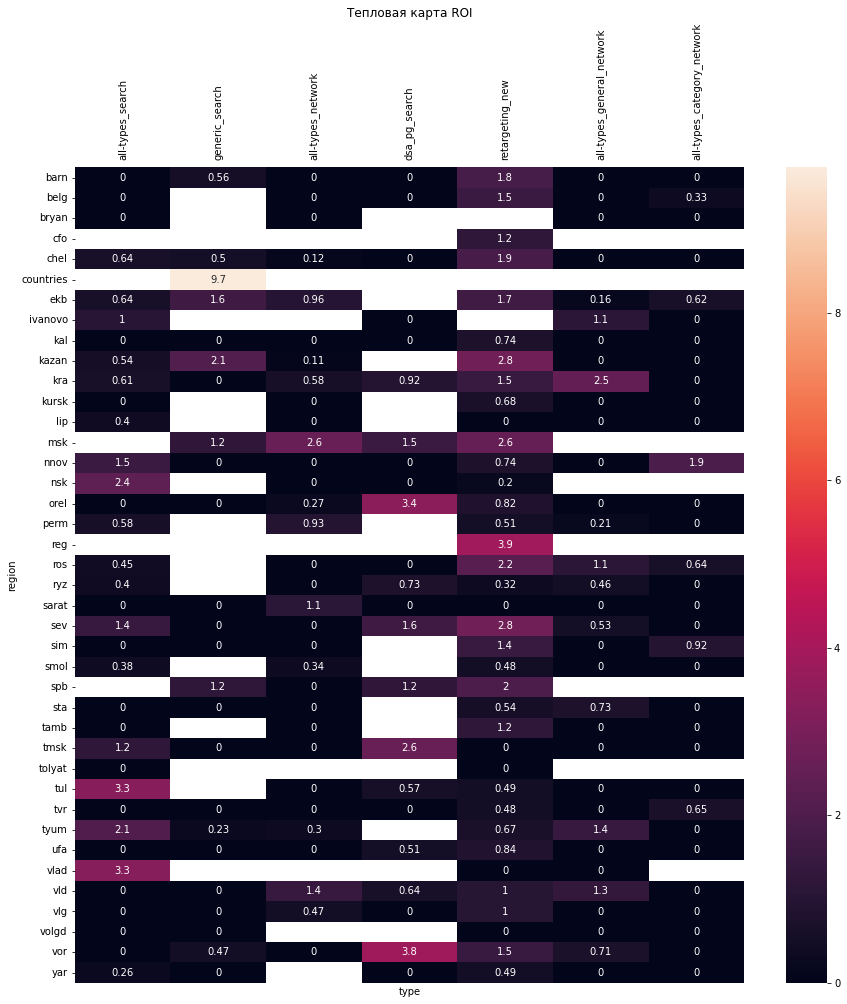

In [22]:
plt.figure(figsize = (15, 15)) # строим тепловую карту
sns.heatmap(promo_reg[slice], annot=True) 
plt.title('Тепловая карта ROI')
plt.tick_params(axis='x', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True, rotation=90)
plt.show()

Высокие значения ROI показывают мероприятия `retargeting_new` и `dsa_pg_search`.

Посмотрим бюджет по рекламным мероприятиям.

In [23]:
budget = df.groupby('type').agg({'costs':'sum','earnings':'sum'}) # группируем данные по типу кампании, суммируя доходы и расходы
budget.sort_values('costs', ascending=False)

,costs,earnings
type,,
,8663492.22,13000660.0
retargeting_new,6727314.20,12664036.0
brand_search,5138480.70,36807082.0
all-types_search,2918797.71,2206496.0
generic_search,2908060.82,2815952.0
dsa_pg_search,2900802.78,3639640.0
all-types_network,2290911.52,732102.0
all-types_general_network,2025734.65,651160.0
general-words_search,1639662.49,1104136.0


Для максимизации эффекта имеет смысл перераспределять достаточно большие бюджеты. Для дальнейшей работы отберем маркетинговые мероприятия с наибольшими бюджетами. 

In [24]:
top_budget = budget.sort_values('costs', ascending=False).head(12).index.to_list() # создаем список кампаний с самыми большими расходами
top_budget

['',
 'retargeting_new',
 'brand_search',
 'all-types_search',
 'generic_search',
 'dsa_pg_search',
 'all-types_network',
 'all-types_general_network',
 'general-words_search',
 'selling-words_search',
 'all-types_category_network',
 'size_search']

Исключим из списка неидентифицированные мероприятия и `brand_search`.

In [25]:
top_budget.remove('') # исключаем неидентифицированные мероприятия и brand_search.
top_budget.remove('brand_search')

Построим графики отобранных рекламных мероприятий по их доходам и расходам.

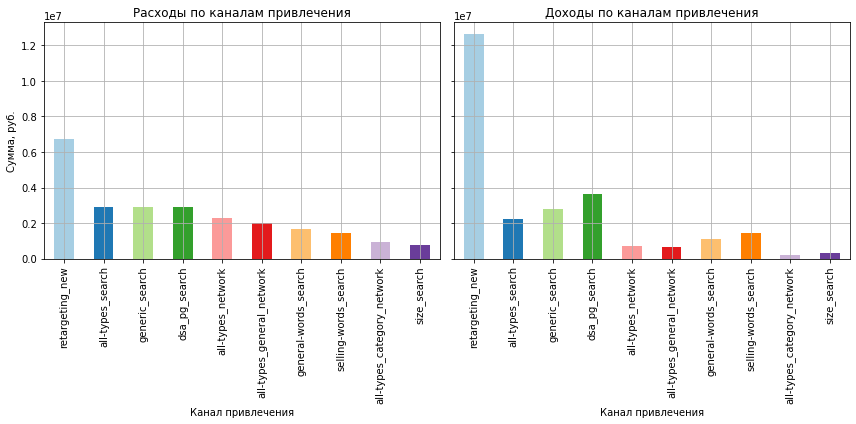

In [26]:
plt.figure(figsize=(12, 6)) # строим диаграммы расходов и доходов 

ax1 = plt.subplot(1,2,1)
ax1 = (budget.loc[top_budget]['costs']   
    .plot( 
        kind='bar', 
        title='Расходы по каналам привлечения',
        grid=True,   
        color=sns.color_palette("Paired"),  
        label='_nolegend_'
    )
) 

ax1.set_ylabel('Сумма, руб.')
ax1.set_xlabel('Канал привлечения')


ax2 = plt.subplot(1,2,2, sharey = ax1)
ax2 = (budget.loc[top_budget]['earnings']   
    .plot(
        kind='bar', 
        title='Доходы по каналам привлечения',
        grid=True,
        color=sns.color_palette("Paired")
    )
) 
ax2.set_ylabel('Доходы, руб.')
ax2.set_xlabel('Канал привлечения')
 
# исключаем наложение графиков друг на друга
plt.tight_layout()

plt.show()

Визуально наиболее эффективные мероприятия - `retargeting_new`, `generic_search` и `dsa_pg_search`.

### Выводы

По результатам исследовательского анализа мы установили, что:
1. Наибольшее число кампаний проводилось в Москве и Санкт-Петербурге.
2. Наивысшим средним ROI обладает мероприятие `brand_search`. Но при расчете бюджета учтем, что емкость этого канала уже исчерпана.
3. Большинство типов рекламных мероприятий используется только в Москве и Санкт-Петербурге. 
4. В срезе кампаний проводимых по большинству регионов высокие значения ROI показывают мероприятия `retargeting_new` и `dsa_pg_search`.
5. Для максимизации эффекта имеет смысл перераспределять достаточно большие бюджеты. Для дальнейшей работы мы отобрали маркетинговые мероприятия с наибольшими бюджетами: `retargeting_new`, `all-types_search`, `generic_search`, `dsa_pg_search`, `all-types_network`, `all-types_general_network`, `general-words_search`,  `selling-words_search`, `all-types_category_network`, `size_search`.
6. По графикам доходов и расходов наиболее эффективные мероприятия - `retargeting_new`, `generic_search` и `dsa_pg_search`.

## Расчет зон роста

Предположим, что ROI маркетинговых мероприятий сохранятся в следующем месяце. Тогда мы сможем перераспределить бюджеты мероприятий так, чтобы максимизировать доход.

Создадим целевую функцию, определяющую доход по отобранным мероприятиям. Это будет линейная функция от затрат на мероприятия с коэффициентами средним ROI по мероприятию.

Рассчитаем ROI по мероприятиям.

In [27]:
agg_roi = df.groupby('type').agg({'costs':'sum', 'earnings':'sum'}).loc[top_budget] # группируем данные по типу кампании, суммируя доходы и считая ROI
agg_roi['roi'] = agg_roi.earnings/agg_roi.costs
agg_roi

,costs,earnings,roi
type,,,
retargeting_new,6727314.20,12664036.0,1.882480
all-types_search,2918797.71,2206496.0,0.755961
generic_search,2908060.82,2815952.0,0.968326
dsa_pg_search,2900802.78,3639640.0,1.254701
all-types_network,2290911.52,732102.0,0.319568
all-types_general_network,2025734.65,651160.0,0.321444
general-words_search,1639662.49,1104136.0,0.673392
selling-words_search,1446711.41,1413096.0,0.976764
all-types_category_network,959406.13,206756.0,0.215504


Определим целевую функцию. Будем максимизировать доход, как линейную функцию от расходов по мероприятиям, умноженных на соответствующий ROI. Для использования функции scypy minimize возьмем с обратным знаком.

In [28]:
def f(x):
    '''
    Линейная функция от расходов по мероприятиям, умноженных на соответствующий ROI
    x - вектор расходов по мероприятиям
    '''
    return (x[0]*coef[0] +x [1]*coef[1] + x[2]*coef[2] + x[3]*coef[3] +
            x[4]*coef[4] + x[5]*coef[5] + x[6]*coef[6] +
            x[7]*coef[7] + x[8]*coef[8] + x[9]*coef[9]) * (-1)

Создадим вектор коэффициентов.

In [29]:
coef = np.array(agg_roi.roi) # cоздадим вектор коэффициентов
coef

array([1.88248023, 0.75596058, 0.96832638, 1.25470095, 0.31956799,
       0.32144388, 0.67339224, 0.97676426, 0.21550415, 0.37021957])

Зададим ограничения для бюджета каждого мероприятия от 0 до суммы всех затрат.

In [30]:
b = (0, agg_roi.costs.sum()) # зададим ограничения для бюджета
bnds = (b,b,b,b,b,b,b,b,b,b) # запишем их в вектор
bnds

((0, 24594940.29),
 (0, 24594940.29),
 (0, 24594940.29),
 (0, 24594940.29),
 (0, 24594940.29),
 (0, 24594940.29),
 (0, 24594940.29),
 (0, 24594940.29),
 (0, 24594940.29),
 (0, 24594940.29))

Создадим вектор начальных значений.

In [31]:
x0 = agg_roi.costs # cоздадим вектор начальных значений - по данным предыдущего месяца
x0

type
retargeting_new               6727314.20
all-types_search              2918797.71
generic_search                2908060.82
dsa_pg_search                 2900802.78
all-types_network             2290911.52
all-types_general_network     2025734.65
general-words_search          1639662.49
selling-words_search          1446711.41
all-types_category_network     959406.13
size_search                    777538.58
Name: costs, dtype: float64

Зададим ограничения для целевой функции: сумма всех расходов на мероприятия всегда постоянна.

In [32]:
cons=({'type': 'eq', # словарь ограничений - строгое равенство
       'fun': lambda x: np.sum(x) - np.sum(agg_roi.costs)} # сумма всех расходов как в предыдущем месяце
      )

Максимизируем функцию.

In [33]:
res = minimize(f, x0, method='SLSQP', constraints=cons, bounds=bnds) # максимизируем функцию
print(res)

     fun: -32670403.170605183
     jac: array([-1.75, -0.75, -1.  , -1.25, -0.5 , -0.25, -0.75, -1.  , -0.25,
       -0.25])
 message: 'Optimization terminated successfully'
    nfev: 418
     nit: 37
    njev: 37
  status: 0
 success: True
       x: array([1.00707281e+07, 2.53429481e+06, 3.38620792e+06, 4.33097708e+06,
       8.13503284e+05, 2.77444673e+05, 1.23087043e+06, 1.95091399e+06,
       2.01298943e-03, 2.73011303e-02])


Сохраним новые расходы на мероприятия.

In [34]:
new_budget = res.x # cохраним новые расходы на мероприятия
np.set_printoptions(precision=2, suppress=True)
print(new_budget)

[10070728.08  2534294.81  3386207.92  4330977.08   813503.28   277444.67
  1230870.43  1950913.99        0.          0.03]


Выведем результаты перераспределения бюджетов. 

In [35]:
print('Results for campaign slice')
print('Old earnings: {:.2f}'.format(np.sum(coef*agg_roi.costs)))
print('New earnings: {:.2f}'.format(np.sum(coef*new_budget)))
print('Increase ratio for slice: {:.2%}'.format((np.sum(coef*new_budget)-np.sum(coef*agg_roi.costs))/np.sum(coef*agg_roi.costs)))
print('-'*20)
print('Total earnings increase: {:.2%}'.format((np.sum(coef*new_budget)-np.sum(coef*agg_roi.costs))/df.earnings.sum()))

Results for campaign slice
Old earnings: 25721234.00
New earnings: 32670403.17
Increase ratio for slice: 27.02%
--------------------
Total earnings increase: 8.88%


В результате перераспределения бюджетов для выбранных маркетинговых активностей доход увеличился на 27%, что дает увеличение общего дохода почти на 9%, что близко к целевому значению.

Посмотрим как перераспределились бюджеты.

In [36]:
data = pd.DataFrame({'old_budget': agg_roi['costs'], 'new_budget': new_budget}) # создаем таблицу со старым и новым бюджетами
((data.new_budget - data.old_budget)/data.old_budget).map('{:.2%}'.format) # считаем разницу

type
retargeting_new                 49.70%
all-types_search               -13.17%
generic_search                  16.44%
dsa_pg_search                   49.30%
all-types_network              -64.49%
all-types_general_network      -86.30%
general-words_search           -24.93%
selling-words_search            34.85%
all-types_category_network    -100.00%
size_search                   -100.00%
dtype: object

Для сравнения построим графики затрат на мероприятия до максимизации и после.

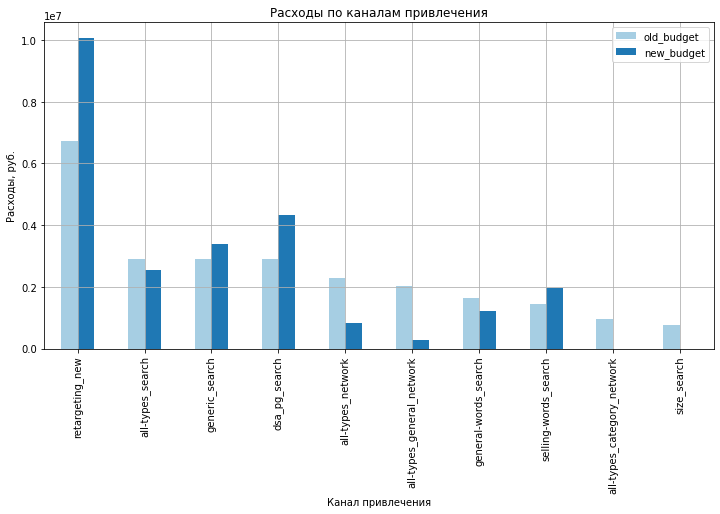

In [37]:
# построим диаграммы расходов

ax = (data
    .plot( 
        kind='bar', 
        title='Расходы по каналам привлечения',
        grid=True,   
        color=sns.color_palette("Paired"),  
        label='_nolegend_',
        figsize=(12,6)
    )
) 

ax.set_ylabel('Расходы, руб.')
ax.set_xlabel('Канал привлечения')
plt.show()

Из тепловой карты мы видим, что одна из маркетинговых активностей `selling-words_search`, бюджет которой увеличен на 34% осуществляется только в Москве. Возможно перераспределение нанесет ущерб кампаниям в регионах. Попробуем ограничить бюджет этой активности начальным значением и заново максимизировать доход.

In [38]:
b = (0, np.sum(agg_roi.costs)) # зададим ограничения для бюджета
bnds = (b,b,b,b,b,b,b,(0,agg_roi.costs[7]),b,b) # запишем их в вектор
bnds

((0, 24594940.29),
 (0, 24594940.29),
 (0, 24594940.29),
 (0, 24594940.29),
 (0, 24594940.29),
 (0, 24594940.29),
 (0, 24594940.29),
 (0, 1446711.41),
 (0, 24594940.29),
 (0, 24594940.29))

In [39]:
cons=({'type': 'eq', # максимизируем функцию
       'fun': lambda x: np.sum(x) - np.sum(agg_roi.costs)}
      )
res = minimize(f, x0, constraints=cons, bounds=bnds)
print(res)

     fun: -37818926.14067112
     jac: array([-2. , -1. , -1. , -1.5, -0.5, -0.5, -0.5, -1. ,  0. , -0.5])
 message: 'Iteration limit reached'
    nfev: 1088
     nit: 100
    njev: 98
  status: 9
 success: False
       x: array([14052162.59,  1769456.2 ,  2796768.93,  5333956.66,        0.  ,
              0.  ,        0.  ,   642593.78,        2.13,        0.  ])


In [40]:
new_budget = res.x # cохраним новые расходы на мероприятия
new_budget

array([14052162.59,  1769456.2 ,  2796768.93,  5333956.66,        0.  ,
              0.  ,        0.  ,   642593.78,        2.13,        0.  ])

Выведем результаты перераспределения бюджетов. 

In [41]:
print('Results for campaign slice')
print('Old earnings: {:.2f}'.format(np.sum(coef*agg_roi.costs)))
print('New earnings: {:.2f}'.format(np.sum(coef*new_budget)))
print('Increase ratio for slice: {:.2%}'.format((np.sum(coef*new_budget)-np.sum(coef*agg_roi.costs))/np.sum(coef*agg_roi.costs)))
print('-'*20)
print('Total earnings increase: {:.2%}'.format((np.sum(coef*new_budget)-np.sum(coef*agg_roi.costs))/df.earnings.sum()))

Results for campaign slice
Old earnings: 25721234.00
New earnings: 37818926.14
Increase ratio for slice: 47.03%
--------------------
Total earnings increase: 15.47%


В результате нового перераспределения бюджетов для выбранных маркетинговых активностей доход увеличился на 54%, что дает увеличение общего дохода почти на 18%. Это заметно выше, чем в предыдущем варианте, посмотрим за счет чего это произошло.

Посмотрим как перераспределились бюджеты.

In [42]:
data = pd.DataFrame({'old_budget': agg_roi['costs'], 'new_budget': new_budget}) # создаем таблицу со старым и новым бюджетами
((data.new_budget - data.old_budget)/data.old_budget).map('{:.2%}'.format) # считаем разницу

type
retargeting_new                108.88%
all-types_search               -39.38%
generic_search                  -3.83%
dsa_pg_search                   83.88%
all-types_network             -100.00%
all-types_general_network     -100.00%
general-words_search          -100.00%
selling-words_search           -55.58%
all-types_category_network    -100.00%
size_search                   -100.00%
dtype: object

Для сравнения построим графики затрат на мероприятия до максимизации и после.

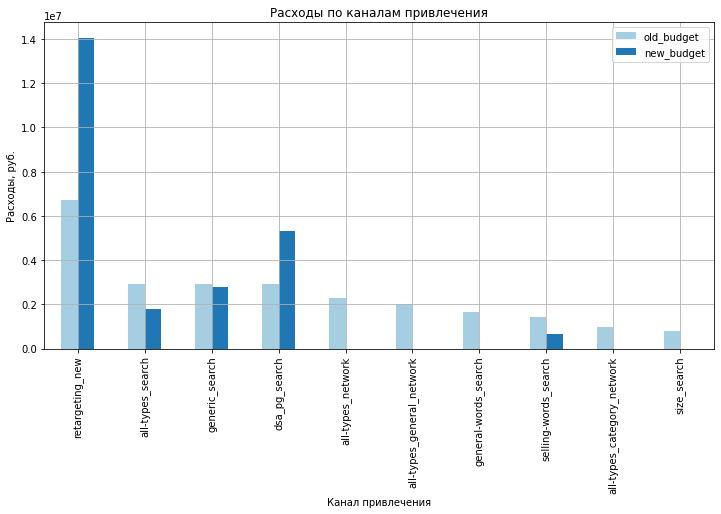

In [43]:
# построим диаграммы расходов

ax = (data
    .plot( 
        kind='bar', 
        title='Расходы по каналам привлечения',
        grid=True,   
        color=sns.color_palette("Paired"),  
        label='_nolegend_',
        figsize=(12,6)
    )
) 

ax.set_ylabel('Расходы, руб.')
ax.set_xlabel('Канал привлечения')
plt.show()

Новое перераспределение дало прирост за счет более чем двукратного увеличения расходов всего на два типа маркетинговых активностей - `retargeting_new` и `dsa_pg_search`. В реальности такое перераспределение не приведет к расчетному росту дохода из-за ограниченной емкости каналов. 

Кажется целесообразным использовать первый вариант перераспределения, а в случае необходимости увеличения бюджета в региональных кампаниях - перераспределять бюджет от `selling-words_search` в `retargeting_new` и `dsa_pg_search`.

### Выводы

1. Мы сформулировали гипотезу, что ROI маркетинговых мероприятий сохранятся в следующем месяце. D этом случае мы сможем перераспределить бюджеты мероприятий так, чтобы максимизировать доход.
2. Мы создали целевую функцию, определяющую доход по отобранным мероприятиям. Это линейная функция от затрат на мероприятия с коэффициентами средним ROI по мероприятию.
3. Будем перераспределять бюджеты для мероприятий, с самыми большими бюджетами. Но исключим `brand_search`, так как емкость этого канала уже исчерпана.
4. Для отобранных мероприятиям мы рассчитали ROI.
5. Мы определили целевую функцию дохода, как линейную функцию от расходов по мероприятиям, умноженных на соответствующий ROI. Для использования функции scypy minimize сумму возьмем с обратным знаком.
6. Для расчетов мы создали вектор коэффициентов - ROI, вектор начальных значений и ограничения для бюджета каждого мероприятия от 0 до суммы всех затрат.
7. Для целевой функции установили ограничения: сумма всех затрат на мероприятия всегда постоянна и равна исходной сумме бюджетов.
8. По итогам максимизации доход при перераспределении бюджета по выбранным кампаниям составил 32 670 403 рублей, что больше исходного на 27%. Для всех кампаний это дает увеличение почти на 9%
9. Итоговое перераспределение:<pre>
retargeting_new                 49.70%
all-types_search               -13.17%
generic_search                  16.44%
dsa_pg_search                   49.30%
all-types_network              -64.49%
all-types_general_network      -86.30%
general-words_search           -24.93%
selling-words_search            34.85%
all-types_category_network    -100.00%
size_search                   -100.00%
</pre>
10. Одна из маркетинговых активностей `selling-words_search`, бюджет которой увеличен на 34% осуществляется только в Москве. Чтобы не нанести ущерб кампаниям в регионах, мы ограничили бюджет этой активности начальным значением и заново максимизировать доход.
11. Доход по выбранным кампаниям после перераспределения увеличился на 47%, но прирост достигнут за счет более чем двукратного увеличения расходов всего на два типа маркетинговых активностей - `retargeting_new` и `dsa_pg_search`. В реальности такое перераспределение не приведет к расчетному росту дохода из-за ограниченной емкости каналов.
12. Мы предложили использовать первый вариант перераспределения, а в случае необходимости увеличения бюджета в региональных кампаниях - перераспределять бюджет от `selling-words_search` в `retargeting_new` и `dsa_pg_search`.

## Итоговые выводы

1. Пропуски в данных отсутствуют. Типы данных во всех столбцах соответствуют содержимому, за исключением столбца `Рентабельность инвестиций в рекламу`, его необходимо преобразование в числовой формат.
2. Мы привели названия столбцов в соответствие с правилами именования: сделали названия столбцов в латинице и строчными символами.
3. Мы привели значения столбца roi к числовому формату.
4. Явных дубликатов в данных не обнаружено.
5. Из названия кампании мы выделили значения региона и вида рекламного мероприятия, используя регулярные выражения.
6. В исходных данных использовано стандартное ROI от гугл аналитики, оно не вполне адекватно отражает эффективность. Мы рассчитали ROI самостоятельно.
7. По результатам исследовательского анализа мы установили, что:<pre>
* Наибольшее число кампаний проводилось в Москве и Санкт-Петербурге.
* Наивысшим средним ROI обладает мероприятие `brand_search`. Но при расчете бюджета учтем, что емкость этого канала уже исчерпана.
* Большинство типов рекламных мероприятий используется только в Москве и Санкт-Петербурге. 
* В срезе кампаний проводимых по большинству регионов высокие значения ROI показывают мероприятия `retargeting_new` и `dsa_pg_search`.
* Для максимизации эффекта имеет смысл перераспределять достаточно большие бюджеты. Для дальнейшей работы мы отобрали маркетинговые мероприятия с наибольшими бюджетами: `retargeting_new`, `all-types_search`, `generic_search`, `dsa_pg_search`, `all-types_network`, `all-types_general_network`, `general-words_search`,  `selling-words_search`, `all-types_category_network`, `size_search`.
* По графикам доходов и расходов наиболее эффективные мероприятия - `retargeting_new`, `generic_search` и `dsa_pg_search`.</pre>
8. Мы сформулировали гипотезу, что ROI маркетинговых мероприятий сохранятся в следующем месяце. D этом случае мы сможем перераспределить бюджеты мероприятий так, чтобы максимизировать доход.
9. Мы создали целевую функцию, определяющую доход по отобранным мероприятиям. Это линейная функция от затрат на мероприятия с коэффициентами средним ROI по мероприятию.
10. Будем перераспределять бюджеты для мероприятий, с самыми большими бюджетами. Но исключим brand_search, так как емкость этого канала уже исчерпана.
11. Для отобранных мероприятиям мы рассчитали ROI.
12. Мы определили целевую функцию дохода, как линейную функцию от расходов по мероприятиям, умноженных на соответствующий ROI. Для использования функции scypy minimize сумму возьмем с обратным знаком.
13. Для расчетов мы создали вектор коэффициентов - ROI, вектор начальных значений и ограничения для бюджета каждого мероприятия от 0 до суммы всех затрат.
14. Для целевой функции установили ограничения: сумма всех затрат на мероприятия всегда постоянна и равна исходной сумме бюджетов.
15. По итогам максимизации доход при перераспределении бюджета по выбранным кампаниям составил 32 670 403 рублей, что больше исходного на 27%. Для всех кампаний это дает увеличение почти на 9%<pre>
Итоговое перераспределение:
retargeting_new                 49.70%
all-types_search               -13.17%
generic_search                  16.44%
dsa_pg_search                   49.30%
all-types_network              -64.49%
all-types_general_network      -86.30%
general-words_search           -24.93%
selling-words_search            34.85%
all-types_category_network    -100.00%
size_search                   -100.00%</pre>
16. Одна из маркетинговых активностей `selling-words_search`, бюджет которой увеличен на 34% осуществляется только в Москве. Чтобы не нанести ущерб кампаниям в регионах, мы ограничили бюджет этой активности начальным значением и заново максимизировать доход.
17. Доход по выбранным кампаниям после перераспределения увеличился на 47%, но прирост достигнут за счет более чем двукратного увеличения расходов всего на два типа маркетинговых активностей - `retargeting_new` и `dsa_pg_search`. В реальности такое перераспределение не приведет к расчетному росту дохода из-за ограниченной емкости каналов.
18. **Мы предложили использовать первый вариант перераспределения, а в случае необходимости увеличения бюджета в региональных кампаниях - перераспределять бюджет от `selling-words_search` в `retargeting_new` и `dsa_pg_search`.**